In [2]:
import os
import cv2
import numpy as np
# tqdm progress bar için kullanılan bir module
from tqdm import tqdm

# set to true to one once, then back to false unless you want to change something in your training data.
REBUILD_DATA = True

In [3]:
class DogVSCat():
    # all images are different size ,so we should resize them befero the cnn
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    
    catcount = 0
    dogcount = 0  
     
    def make_training_data(self):
        
        for label in self.LABELS:
            print("labels : " + str(label))
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    # kedi ve köpekleri ayırt etmede renk farklı çokda önemli değildir. Ana nokta bu işte 
                    # patterns ler bu sebeple imajları gray scale olarak çeviriyoruz
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    # resize the all images in 50*50
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # işlemden geçmiş tüm img leri training_data listesine appand edeceğiz
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]] ])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                                               
                except Exception as e:
                    pass
                    #print(str(e))
                                             
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',self.catcount)
        print('Dogs:',self.dogcount)  
                                               
if REBUILD_DATA:
    dogvscat = DogVSCat()
    dogvscat.make_training_data()

  0%|          | 0/12501 [00:00<?, ?it/s]

labels : PetImages/Cat


  0%|          | 10/12501 [00:00<02:12, 94.47it/s]

labels : PetImages/Dog


100%|██████████| 12501/12501 [00:53<00:00, 233.16it/s]


Cats: 12476
Dogs: 12470


In [9]:
training_data = np.load("training_data.npy",allow_pickle=True)
print(len(training_data))

print(training_data)

24946
[[array([[ 65,  64,  61, ...,  52,  51,  50],
       [ 50,  52,  46, ...,  54,  50,  53],
       [ 53,  48,  49, ...,  35,  35,  36],
       ...,
       [ 39,  45,  39, ..., 155, 149, 151],
       [ 37,  46,  46, ..., 156, 146, 152],
       [ 32,  31,  25, ..., 157, 151, 154]], dtype=uint8)
  array([0., 1.])]
 [array([[254, 254, 254, ..., 134, 160, 124],
       [254, 254, 254, ..., 150, 161, 158],
       [246, 251, 253, ..., 151, 133, 143],
       ...,
       [212, 129, 213, ..., 207, 209, 226],
       [205, 228, 196, ..., 200, 212, 236],
       [184, 182, 204, ..., 243, 243, 245]], dtype=uint8)
  array([0., 1.])]
 [array([[ 88,  88,  88, ..., 169, 155, 119],
       [ 88,  88,  88, ..., 199, 161, 144],
       [ 88,  88,  88, ..., 115, 122, 168],
       ...,
       [160, 175, 158, ..., 117, 114, 164],
       [168, 180, 107, ..., 142, 113, 126],
       [183, 164, 158, ..., 180, 119, 149]], dtype=uint8)
  array([1., 0.])]
 ...
 [array([[169, 170, 175, ..., 230, 229, 223],
       [17

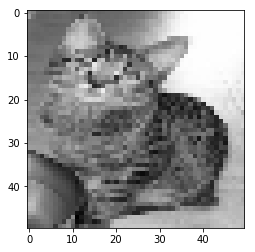

[1. 0.]


In [10]:
import matplotlib.pyplot as plt

plt.imshow(training_data[18000,0], cmap="gray")
plt.show()

print(training_data[18000,1])

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input is 1 images, 32 output , 5 is the kernel size 5*5
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # burada yapay bir x input oluşturluyor flatten layer'ın input size ını belirlemek için.
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        print("__init__")
        print(self._to_linear)
        
        # _to_linear değeri ile fully connected layer öncesi input size belli
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        #print("#conv")
        #print(x.shape)
        
        # fcn den önce flatten layer size belirlenmesi.
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

__init__
512
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [32]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [33]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0

y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

print(val_size)

2494


In [34]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [37]:
BATCH_SIZE = 100
EPOCH = 2

for epoch in range(EPOCH):
    # tdqm argu. fist staring point ; second last; last step size
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_x = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)

100%|██████████| 225/225 [01:27<00:00,  2.56it/s]

tensor(0.1516, grad_fn=<MseLossBackward>)


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:08<00:00, 292.64it/s]

Accuracy:  0.629
